In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial
import tqdm

In [9]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()
yuima = importr("yuima")

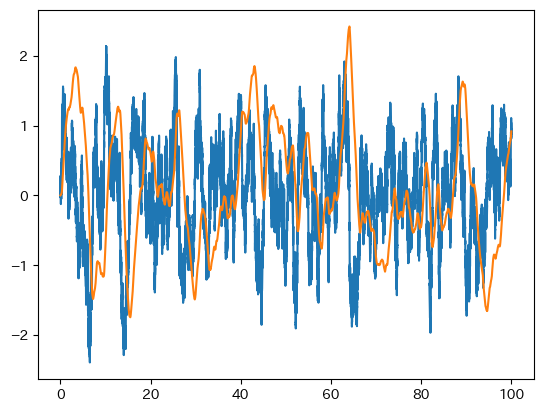

In [59]:
import numpy as np
import rpy2

def linear_Z(theta, t_max, dt, seed):
    # np.random.seed(seed)

    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]

    ro.r('options(warn=-1)')

    ro.r(f'drift = c("-theta21*x1-theta22*x2", "theta3*x1")')
    ro.r(f'diffusion = matrix(c("theta1", "0", "0", "0"), 2, 2)')
    ro.r('model = setModel(drift=drift, diffusion=diffusion, state.var=c("x1", "x2"))')

    N = int(t_max/dt)
    ro.r(f'samp = setSampling(Terminal={t_max}, n={N})')
    ro.r('yuima = setYuima(model=model, sampling=samp)')
    
    ro.r(f'set.seed({seed})')
    ro.r('xinit = c(0, 0)')
    ro.r(f'true.par = list(theta1={theta1}, theta21={theta21}, theta22={theta22}, theta3={theta3})')
    ro.r('sim = simulate(yuima, xinit=xinit, true.par=true.par)')
    
    Z_t = ro.r('sim@data@original.data')

    return Z_t.T

# 使用例
theta = [1,1,1,1]
t_max = 100.0  # 最大時間の例
dt = 0.001  # タイムステップの例
seed = 0  # ランダムシードの例

Z_t = linear_Z(theta, t_max, dt, 2)
# Z_tの形を(N+1, 2)に変更
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[0])
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[1])

$$
dX_t = -X_t dt + dW_t\\
dY_t = X_t dt
$$

$Y_{40} = \sum_{i=1}^{40}X_{t_i}\Delta t_i = 0$

$Y_{41} = Y_{40} + X_{t_{41}}\Delta t_{41} = X_{t_{41}}\Delta t_{41}$

In [11]:
def compute_a(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    An = np.array([np.linalg.matrix_power(A0,n) for n in np.arange(k0+1)])
    x0 = np.array([a0,a1])
    xn = np.einsum('ijk,k->ij',An,x0)
    return xn[:,0]
def compute_b(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    b0 = 0
    b1 = -theta22
    B0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    Bn = np.array([np.linalg.matrix_power(B0,n) for n in np.arange(k0+1)])
    x0 = np.array([b0,b1])
    xn = np.einsum('ijk,k->ij',Bn,x0)
    return xn[:,0]

In [12]:
def compute_s(a,theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0 )
    l = np.arange(k0 )
    
    m_grid, k_grid,l_grid = np.meshgrid(m, k, l,indexing='ij')
    valid_mask = (k_grid + l_grid == m_grid)

    m_grid = m_grid*valid_mask
    k_grid = k_grid*valid_mask
    l_grid = l_grid*valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = a[l_grid] * valid_mask
    
    fact_11 = 1/((m_grid +1)*scipy.special.factorial(k_grid )*scipy.special.factorial(l_grid))
    fact_12 = 1/((m_grid +2)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid))
    fact_22 = 1/((m_grid +3)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid+1))
    
    mat11 = np.einsum('ijk->i',theta1**2 * a_k * a_l* fact_11)
    mat12 = np.einsum('ijk->i',theta1**2 * theta3  * a_k * a_l * fact_12)
    mat22 = np.einsum('ijk->i',theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s




In [279]:
import numpy as np
import scipy.special

def update_2(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    matrix = np.array([
        [np.sum(x_previous * x_previous), np.sum(x_previous * y_previous)],
        [np.sum(y_previous * x_previous), np.sum(y_previous * y_previous)]
    ])
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(2, k0 + 1)], axis=0)
    
    vector = -np.array([np.sum(x_previous * (x_current - x_previous - correction_x)),
                        np.sum(y_previous * (x_current - x_previous - correction_x))])
    
    return np.linalg.inv(matrix) @ vector / h

def update_1(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    
    s = compute_s(a, theta, k0)
    s_11 = s[:, 0, 0]
    correction_term = np.sum([s_11[i] * (h**i) for i in range(1, k0 + 1)])
    
    return np.sqrt(np.mean((x_current - x_previous - correction_x)**2 / h) - correction_term)

def update_3(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    correction_y = np.sum([theta[3] * (a[i] * x_previous + b[i] * y_previous) * (h**(i + 1)) / scipy.special.factorial(i + 1) for i in range(1, k0 + 1)], axis=0)
    
    numerator1 = np.sum(x_previous * (y_current - y_previous - correction_y))
    numerator2 = np.sum(x_previous * (x_current - x_previous - correction_x))
    denominator = np.sum(x_previous * x_previous)
    
    if denominator == 0:
        raise ValueError("Denominator in calculation is zero, check inputs.")
    
    result = numerator1 / (denominator * h) - 2 * (theta[3] * numerator2) / (denominator * 4)
    
    return result

def update_1_final(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    correction_y = np.sum([theta[3] * (a[i-1] * x_previous + b[i-1] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 2)], axis=0)
    
    vec_x = h**(-1/2) * (x_current - x_previous - correction_x)
    vec_y = h**(-3/2) * (y_current - y_previous - correction_y)
    
    s = compute_s(a, theta, k0)
    S = np.sum([s[i] * h**i for i in range(1, k0 + 1)], axis=0)
    
    term1 = 2 * (np.mean(vec_x * vec_x) - S[0, 0])
    term2 = -6 * (np.mean(vec_x * vec_y) - S[0, 1]) / theta[3]
    term3 = 6 * (np.mean(vec_y * vec_y) - S[1, 1]) / theta[3]**2
    
    return np.sqrt(term1 + term2 + term3)

In [64]:
def update_2(theta, Z, k0,h):
    x = Z[0][1:]
    y = Z[1][1:]
    x_ = Z[0][:-1]
    y_ = Z[1][:-1]
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    matrix = np.zeros((2,2))
    matrix[0,0] = np.sum(x_*x_)
    matrix[0,1] = np.sum(x_*y_)
    matrix[1,0] = np.sum(y_*x_)
    matrix[1,1] = np.sum(y_*y_)
    f = 0
    for i in range(1,k0+1):
        if i == 1:
            pass
        else:
            f += (a[i]*x_ + b[i]*y_) * (h**i)/scipy.special.factorial(i)
    vector = -np.array([np.sum(x_*(x - x_ - f)),np.sum(y_*(x- x_ - f))])
    return np.linalg.inv(matrix) @ vector / h 


In [116]:
def update_1(theta,Z,k0,h):
    x = Z[0][1:]
    y = Z[1][1:]
    x_ = Z[0][:-1]
    y_ = Z[1][:-1]
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    f = 0
    for i in range(1,k0+1):
        f += (a[i]*x_ + b[i]*y_) * (h**i)/scipy.special.factorial(i)
    s = compute_s(a,theta,k0)
    # s の (1,1)成分を抜き
    s_11 = s[:,0,0]
    g = 0
    for i in range(1,k0+1):
        g += s_11[i] * (h**i)
    return np.sqrt(np.mean((x-x_ - f)**2/h )- g) 

In [177]:

def update_3(theta, Z, k0, h):
    x = Z[0][1:]
    y = Z[1][1:]
    x_ = Z[0][:-1]
    y_ = Z[1][:-1]
    
    # Assuming compute_a and compute_b are defined and return lists/arrays
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    f = np.zeros_like(x_)  # initialize f and g as arrays to accumulate results
    g = np.zeros_like(x_)

    for i in range(1, k0 + 1):
        factor_i = h**i / scipy.special.factorial(i)
        factor_i1 = h**(i + 1) / scipy.special.factorial(i + 1)
        f += (a[i] * x_ + b[i] * y_) * factor_i
        g += theta[3] * (a[i] * x_ + b[i] * y_) * factor_i1
    
    # Ensure proper usage of parentheses to clarify order of operations
    numerator1 = np.sum(x_ * (y - y_ - g))
    numerator2 = np.sum(x_ * (x - x_ - f))
    denominator = np.sum(x_ * x_)

    # Check to avoid division by zero
    if denominator == 0:
        raise ValueError("Denominator in calculation is zero, check inputs.")

    result = numerator1 / (denominator * h) - 2*(theta[3] * numerator2) / (denominator * 4)
    
    return result

In [272]:
def update_1_(theta, Z, k0, h):
    x = Z[0][1:]
    y = Z[1][1:]
    x_ = Z[0][:-1]
    y_ = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    f = 0
    g = 0
    for i in range(1, k0 + 1):
        f += (a[i] * x_ + b[i] * y_) * (h**i) / scipy.special.factorial(i)
    for i in range(1, k0 + 2):
        g += theta[3] * (a[i-1] * x_ + b[i-1] * y_) * (h**i) / scipy.special.factorial(i)
    
    vec1 = h**(-1/2) * (x - x_ - f)
    vec2 = h**(-3/2) * (y - y_ - g)
    s = compute_s(a,theta,k0)
    S = np.zeros((2, 2))
    for i in range(1,k0+1):
        S += s[i] * h**i
        
    # 2*2の行列を作成するためのテンソル積
    return np.sqrt(2*( np.mean(vec1*vec1) -S[0,0]) -6 * (np.mean(vec1*vec2) - S[0,1])/theta[3] + 6 * (np.mean(vec2*vec2) - S[1,1])/theta[3]/theta[3])

In [282]:

# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 1000.0
dt = 0.01
h = 0.5

# 複数のseedでループ
seeds = range(200)
k0_range = range(1, 10)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())
theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2,axis =0)) for k in k0_range}

# 結果の表示
for k in k0_range:
    mean_str = np.array2string(theta_means[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    std_str = np.array2string(theta_stds[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    std_0_str = np.array2string(theta_stds_0[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    print(f"k0 = {k}: mean = {mean_str}, std = {std_str}")

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_t =", theoretical_std_0_str)

for k in k0_range:
    std_0_str = np.array2string(theta_stds_0[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    print(f"std_0 = {std_0_str}")

k0 = 1: mean = [1.0040 0.9500 0.7488 0.8670], std = [0.0139 0.0342 0.0339 0.0070]
k0 = 2: mean = [1.0107 1.0137 0.9267 0.9578], std = [0.0141 0.0510 0.0430 0.0074]
k0 = 3: mean = [0.9983 1.0170 0.9782 0.9815], std = [0.0137 0.0562 0.0465 0.0080]
k0 = 4: mean = [0.9946 1.0014 0.9899 0.9856], std = [0.0136 0.0577 0.0472 0.0083]
k0 = 5: mean = [0.9930 0.9919 0.9912 0.9863], std = [0.0135 0.0578 0.0472 0.0083]
k0 = 6: mean = [0.9923 0.9873 0.9899 0.9863], std = [0.0134 0.0574 0.0470 0.0084]
k0 = 7: mean = [0.9921 0.9855 0.9887 0.9862], std = [0.0134 0.0571 0.0468 0.0084]
k0 = 8: mean = [0.9921 0.9849 0.9881 0.9862], std = [0.0134 0.0569 0.0467 0.0084]
k0 = 9: mean = [0.9920 0.9847 0.9878 0.9862], std = [0.0134 0.0569 0.0466 0.0084]
std_t = [0.0112 0.0447 0.0447 0.0065]
std_0 = [0.0144 0.0605 0.2535 0.1332]
std_0 = [0.0177 0.0528 0.0850 0.0428]
std_0 = [0.0138 0.0587 0.0514 0.0202]
std_0 = [0.0146 0.0577 0.0482 0.0166]
std_0 = [0.0152 0.0583 0.0480 0.0161]
std_0 = [0.0155 0.0588 0.0480 0.01

In [276]:

# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.01
h = 0.5

# 複数のseedでループ
seeds = range(200)
k0_range = range(1, 10)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())
theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2,axis =0)) for k in k0_range}

# 結果の表示
for k in k0_range:
    mean_str = np.array2string(theta_means[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    std_str = np.array2string(theta_stds[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    std_0_str = np.array2string(theta_stds_0[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    print(f"k0 = {k}: mean = {mean_str}, std = {std_str}")

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_t =", theoretical_std_0_str)

for k in k0_range:
    std_0_str = np.array2string(theta_stds_0[k], formatter={'float_kind':lambda x: f"{x:.4f}"})
    print(f"std_0 = {std_0_str}")

k0 = 1: mean = [1.0027 0.9597 0.7752 0.8642], std = [0.0426 0.1122 0.1159 0.0237]
k0 = 2: mean = [1.0091 1.0256 0.9611 0.9555], std = [0.0430 0.1717 0.1445 0.0256]
k0 = 3: mean = [0.9971 1.0302 1.0157 0.9799], std = [0.0419 0.1906 0.1555 0.0278]
k0 = 4: mean = [0.9929 1.0159 1.0287 0.9845], std = [0.0413 0.1975 0.1570 0.0287]
k0 = 5: mean = [0.9912 1.0069 1.0305 0.9853], std = [0.0411 0.1990 0.1566 0.0289]
k0 = 6: mean = [0.9905 1.0025 1.0295 0.9854], std = [0.0410 0.1984 0.1557 0.0290]
k0 = 7: mean = [0.9903 1.0007 1.0284 0.9854], std = [0.0409 0.1977 0.1551 0.0290]
k0 = 8: mean = [0.9902 1.0000 1.0278 0.9854], std = [0.0409 0.1972 0.1548 0.0290]
k0 = 9: mean = [0.9902 0.9998 1.0275 0.9854], std = [0.0409 0.1969 0.1546 0.0290]
std_t = [0.0354 0.1414 0.1414 0.0204]
std_0 = [0.0427 0.1192 0.2529 0.1379]
std_0 = [0.0440 0.1736 0.1496 0.0513]
std_0 = [0.0420 0.1930 0.1563 0.0343]
std_0 = [0.0419 0.1981 0.1596 0.0326]
std_0 = [0.0420 0.1991 0.1595 0.0324]
std_0 = [0.0421 0.1985 0.1585 0.03

In [185]:
theta = [0.5,0.5,0.5,0.5]
t_max = 100.0
dt = 0.01
h = 0.1
seed = 2
Z_t = linear_Z([1,1,1,1], t_max, dt, seed)
Z = Z_t[:,::int(h//dt)]
for k0 in range(1, 10):
    theta_2 = update_2(theta, Z, k0, h)
    theta[1] = theta_2[0]
    theta[2] = theta_2[1]
    theta_1 = update_1(theta, Z, k0, h)
    theta[0] = theta_1
    theta_3 = update_3(theta, Z, k0, h)
    theta[3] = theta_3





theta_1 = [0.9634205784324544, 0.8764208329247841, 0.8341202715227276, 0.9849823173341049]
[0.87642083 0.83412027]
theta_2 = [1.0034525138341543, 0.8737468208450223, 0.8706722906790973, 1.0061937469030227]
[0.87642083 0.88412027]
theta_3 = [1.0068856785608096, 0.8722290416189774, 0.87232107070946, 1.007140434387883]
[0.8780875  0.88412027]
theta_4 = [1.007132153517224, 0.8719536051097644, 0.8723030909668484, 1.0071800897936112]
[0.87804583 0.8840786 ]
theta_5 = [1.0071525454413588, 0.8719289098524755, 0.8722914822677289, 1.0071817694259932]
[0.87804583 0.88407944]
theta_6 = [1.0071542053681892, 0.8719272722536292, 0.8722899474326374, 1.007181841119351]
[0.87804585 0.88407944]
theta_7 = [1.007154343001668, 0.8719272008196329, 0.8722898107749735, 1.0071818442127047]
[0.87804585 0.88407944]
theta_8 = [1.007154354695206, 0.871927201016493, 0.8722898016725673, 1.007181844353501]
[0.87804585 0.88407944]
theta_9 = [1.00715435570807, 0.8719272014596591, 0.872289801269782, 1.0071818443605278]
[

In [264]:
dt = 0.0001
h = 0.9
theta3_list = []
for seed in range(30):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta3_list.append(update_3(theta, Z, 3,h))
theta3_list = np.array(theta3_list)
print(theta3_list.mean(),theta3_list.std())
print(np.sqrt(np.mean((theta3_list - 1)**2,axis=0)))


R[write to console]: 



RRuntimeError: 

In [170]:
h = 0.1
theta3_list = []
for seed in range(30):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta3_list.append(update_3(theta, Z, 1,h))
theta3_list = np.array(theta3_list)
print(theta3_list.mean(),theta3_list.std())
print(np.sqrt(np.mean((theta3_list - 1)**2,axis=0)))
print(h/np.sqrt(6*t_max))


0.9995936846695905 0.00569657900204111
0.005711051083138854
0.004082482904638631


In [176]:
h = 0.1
theta3_list = []
for seed in range(30):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta3_list.append(update_3(theta, Z, 1,h))
theta3_list = np.array(theta3_list)
print(theta3_list.mean(),theta3_list.std())
print(np.sqrt(np.mean((theta3_list - 1)**2,axis=0)))
print(h/np.sqrt(6*t_max))

1.0009753324868278 0.003248301544280625
0.003391568425144556
0.004082482904638631


In [173]:
h = 0.1
theta3_list = []
for seed in range(30):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta3_list.append(update_3(theta, Z, 2,h))
theta3_list = np.array(theta3_list)
print(theta3_list.mean(),theta3_list.std())
print(np.sqrt(np.mean((theta3_list - 1)**2,axis=0)))
print(h/np.sqrt(6*t_max))


0.998204199646017 0.009164587474066939
0.00933887372658984
0.004082482904638631


In [161]:
h = 0.05
theta3_list = []
for seed in range(30):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta3_list.append(update_3(theta, Z, 10,h))
theta3_list = np.array(theta3_list)
print(theta3_list.mean(),theta3_list.std())
print(np.sqrt(np.mean((theta3_list - 1)**2,axis=0)))
print(h/np.sqrt(6*t_max))

0.998480632118218 0.005457825905936705
0.00566536339343771
0.0020412414523193153


In [154]:
print(h/np.sqrt(6*t_max))

0.03674234614174767


$\frac{n^{1/2} }{h^{1/2}  } (\hat{\theta}_3 - \theta^* )  = N(0,1/6)$

stdは $h^{1/2}/n^{1/2}/6^{1/2} = h/(T)^{1/2}/6^{1/2} $

In [147]:
theta3_list

In [140]:
theta1_list = np.array(theta1_list)
theta1_list

array([0.97618348])

In [89]:
theta1_list.mean(),theta1_list.std()

In [60]:
h = 0.5
theta2_list = []
for seed in range(100):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta2_list.append(update_2(theta, Z, 1,h))
theta2_list = np.array(theta2_list)
print(np.sqrt(np.mean((theta2_list - 1)**2,axis=0)))

[0.10277543 0.25754024]


In [61]:
h = 0.5
theta2_list = []
for seed in range(100):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta2_list.append(update_2(theta, Z, 2,h))
theta2_list = np.array(theta2_list)
print(np.sqrt(np.mean((theta2_list - 1)**2,axis=0)))

[0.10277543 0.10851768]


In [62]:
h = 0.5
theta2_list = []
for seed in range(100):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta2_list.append(update_2(theta, Z, 3,h))
theta2_list = np.array(theta2_list)
print(np.sqrt(np.mean((theta2_list - 1)**2,axis=0)))

[0.10624953 0.10851768]


In [63]:
h = 0.5
theta2_list = []
for seed in range(100):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    theta2_list.append(update_2(theta, Z, 10,h))
theta2_list = np.array(theta2_list)
print(np.sqrt(np.mean((theta2_list - 1)**2,axis=0)))

[0.10492983 0.10793029]


In [27]:
import numpy as np
import scipy.special

def calculate_d_e(s):
    k0 = np.shape(s)[0] - 1  # k0を変更
    d = np.zeros_like(s)
    e = np.zeros(k0 + 1)
    
    d[0] = np.linalg.inv(s[0])
    
    for k in range(1, k0 + 1):
        p_idx, q_idx ,r_idx= np.meshgrid(np.arange(k), np.arange(k),np.arange(k), indexing='ij')
        valid_indices = (p_idx+q_idx+r_idx == k-1)
        factorial_k = scipy.special.factorial(k -1)
        
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        r_valid = r_idx[valid_indices]
        
        comb_factor = 1/ (k *scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid) * scipy.special.factorial(r_valid))
        
        d[k] =  -np.einsum('n,nij,njk,nkl->il', comb_factor,d[p_valid], s[q_valid + 1], d[r_valid])
    
    e[0] = np.log(np.linalg.det(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx = np.meshgrid(np.arange(k),np.arange(k),indexing = 'ij')
        valid_indices = (p_idx+q_idx == k-1)
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        
        comb_factor = 1 / (k* scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid))
        e[k] = -np.einsum('n,nij,nij->', comb_factor, d[p_valid + 1], s[q_valid])
        
    return d, e


In [7]:
def D(a,b,Z,theta,k0,h):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    x_ = x_[:,np.newaxis]
    y_ = y_[:,np.newaxis]
    k = np.arange(1,k0+1)
    f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    k = np.arange(1,k0+2)
    g = np.sum(theta3*(a[k-1] * x_ +  b[k-1] *y_) * h**k/scipy.special.factorial(k),axis = 1)
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    Dx = h**(-1/2) *(x - x_ - f)
    Dy = h**(-3/2) *(y - y_ - g)
    return np.array([Dx,Dy])

In [29]:
def QL(Z,theta,k0,h):
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    s = compute_s(a,theta,k0)
    d, e = calculate_d_e(s)
    D_ = D(a,b,Z,theta,k0,h)
    k = np.arange(k0+1)
    Q = - np.einsum('k,kj->',h**k, (np.einsum('kpq,pj,qj->kj ',d,D_,D_) + e[:,np.newaxis]))/2
    return Q

In [14]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.01
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

  0%|          | 0/10 [00:03<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (2,10000) (2,) 

In [9]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.05
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),theta,bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.983940,1.018181,1.038832,1.000644
k=1 std,0.010663,0.093922,0.138063,0.001806
k=2 mean,0.996204,0.990037,1.065931,1.000410
k=2 std,0.011411,0.090489,0.141290,0.001807
k=3 mean,0.996216,0.990028,1.063772,1.000416
k=3 std,0.011411,0.090072,0.141211,0.001807
k=4 mean,0.996216,0.990021,1.063740,1.000416
k=4 std,0.011411,0.090076,0.141208,0.001807
k=5 mean,0.996216,0.990024,1.063747,1.000416
k=5 std,0.011411,0.090075,0.141212,0.001807


In [23]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.1
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.964989,1.009191,1.010862,1.000902
k=1 std,0.013406,0.082036,0.135199,0.003230
k=2 mean,0.988365,0.944254,1.065697,0.999928
k=2 std,0.014114,0.079922,0.140347,0.003218
k=3 mean,0.988352,0.940176,1.061506,0.999966
k=3 std,0.014115,0.078322,0.140725,0.003219
k=4 mean,0.988352,0.940086,1.061281,0.999965
k=4 std,0.014115,0.078341,0.140674,0.003219
k=5 mean,0.988352,0.940100,1.061279,0.999965
k=5 std,0.014115,0.078341,0.140670,0.003219


In [10]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.3
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),theta,bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.918010,0.988693,0.908100,1.004342
k=1 std,0.019111,0.108078,0.125875,0.010671
k=2 mean,0.980594,0.864733,1.062035,0.995009
k=2 std,0.025317,0.085336,0.146026,0.010625
k=3 mean,0.978641,0.814892,1.054246,0.995651
k=3 std,0.025229,0.071549,0.146943,0.010611
k=4 mean,0.978707,0.814022,1.049167,0.995642
k=4 std,0.025244,0.071809,0.145883,0.010601
k=5 mean,0.978721,0.814212,1.049193,0.995637
k=5 std,0.025246,0.071902,0.145872,0.010602


In [11]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.5
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),theta,bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.875491,0.984308,0.796071,1.023711
k=1 std,0.034238,0.086661,0.118193,0.018422
k=2 mean,0.973602,0.851691,1.036272,0.996981
k=2 std,0.040931,0.071838,0.133608,0.018162
k=3 mean,0.964659,0.726938,1.041842,0.999073
k=3 std,0.039965,0.052867,0.143381,0.018254
k=4 mean,0.965226,0.726313,1.020893,0.999296
k=4 std,0.039988,0.054011,0.139743,0.018222
k=5 mean,0.965315,0.726976,1.020988,0.999225
k=5 std,0.039989,0.054103,0.139606,0.018224


In [12]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.9
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),theta,bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),theta,bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.813382,0.925798,0.593027,1.071593
k=1 std,0.054845,0.082189,0.106427,0.059105
k=2 mean,0.979877,0.926456,0.985261,0.978396
k=2 std,0.072528,0.133435,0.127925,0.052701
k=3 mean,0.928038,0.580307,1.078314,0.990772
k=3 std,0.063891,0.050992,0.169925,0.054702
k=4 mean,0.933007,0.591623,0.962289,0.997529
k=4 std,0.064257,0.056061,0.148296,0.054288
k=5 mean,0.933961,0.596301,0.961099,0.996553
k=5 std,0.064362,0.056697,0.145739,0.054272


ここまで検証した

In [54]:
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.0001
h = 0.99
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(100)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta21','theta22','theta3']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


,theta1,theta21,theta22,theta3
k=1 mean,0.745777,0.928451,0.615027,1.089059
k=1 std,0.155339,0.307534,0.332493,0.233147
k=2 mean,0.924243,0.992852,1.130827,0.953481
k=2 std,0.209223,0.448171,0.483216,0.168950
k=3 mean,0.856247,0.514811,1.166119,0.974154
k=3 std,0.180603,0.214424,0.510142,0.179776
k=4 mean,0.866113,0.525295,1.029847,0.983083
k=4 std,0.185210,0.230629,0.471998,0.193434
k=5 mean,0.869225,0.544291,1.009422,0.981154
k=5 std,0.183533,0.226692,0.445931,0.188135


theta21の図形を調べる

In [31]:
import pandas as pd

In [30]:

theta2_ = {}
for k in range(1, 5):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(30)):
    theta = [1, 1, 1, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.9
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 5, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 5):
        if k == 1:
            for i in range(100):
                Q_list[i] = QL(Z, np.array([1, theta2[i], 1, 1]), k, h)
            index = np.argmax(Q_list)
            theta2_[k] = np.append(theta2_[k], theta2[index])
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 1]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 1]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 1]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 1]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


100%|██████████| 30/30 [01:51<00:00,  3.72s/it]


NameError: name 'pd' is not defined

In [32]:

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()

,1,2,3,4
count,30.000000,30.000000,30.000000,30.000000
mean,0.908872,0.970868,0.651165,0.630365
std,0.098241,0.170933,0.093992,0.068932
min,0.715657,0.711259,0.509375,0.521402
25%,0.829066,0.873723,0.599293,0.581075
50%,0.917273,0.939133,0.640181,0.626754
75%,0.967677,1.049784,0.681843,0.663469
max,1.169293,1.556234,0.980385,0.817536


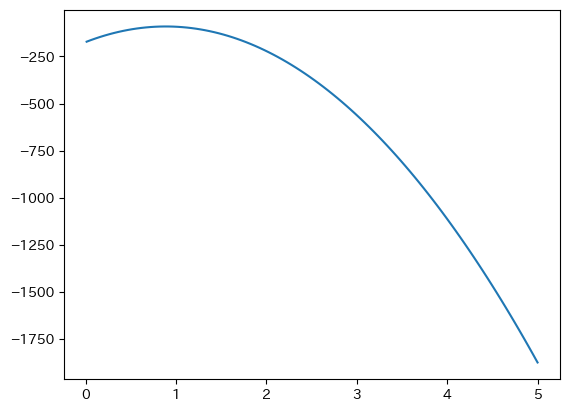

In [19]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
theta2 = np.linspace(0.01,5,100)
Q_list = theta2.copy()
for i in range(100):
    Q_list[i] = QL(Z,np.array([1,theta2[i],1,1]),1,h)
plt.plot(theta2,Q_list)

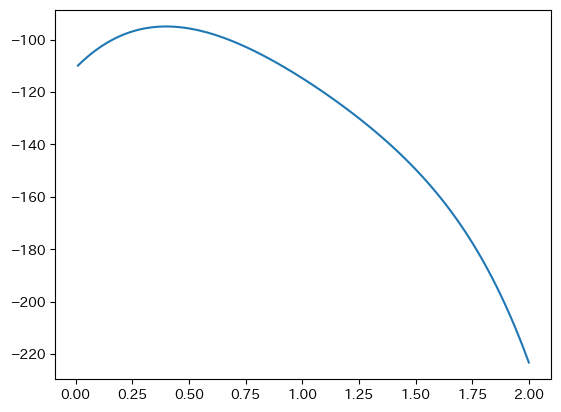

In [20]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
theta2 = np.linspace(0.01,2,100)
Q_list = theta2.copy()
for i in range(100):
    Q_list[i] = QL(Z,np.array([1,theta2[i],1,1]),2,h)
plt.plot(theta2,Q_list)

$k_0 = 3$でargmaxが1からズレる

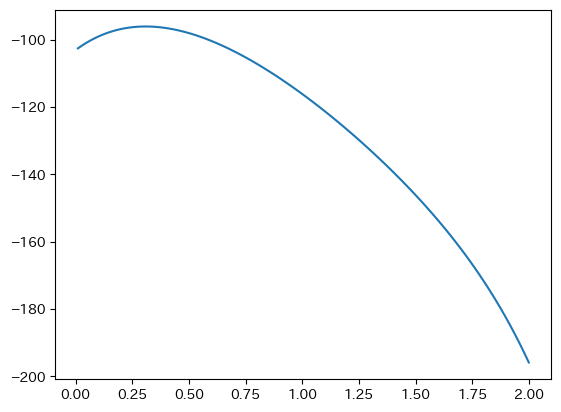

In [21]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
theta2 = np.linspace(0.01,2,100)
Q_list = theta2.copy()
for i in range(100):
    Q_list[i] = QL(Z,np.array([1,theta2[i],1,1]),3,h)
plt.plot(theta2,Q_list)

ベイズ推定をメトロポリス法により実行する

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def target_distribution_1(x,alpha,theta21,theta22,theta3,k0,Z,n,h):
    if 0.0001 <= x <= 10:
        return np.log(1 / (2 - 0.1)) + QL(Z, [x, theta21, theta22, theta3], k0, h)/(alpha**2)/(n)
    else:
        return -np.inf
def target_distribution_2(x,alpha,theta1,theta3,k0,Z,n,h):
    if np.all((0.01 <= x[0]) & (x[0] <= 2) & (0.01 <= x[1]) & (x[1] <= 2)):
        return np.log(1 / (2 - 0.01)**2) + QL(Z, np.array([theta1, x[0], x[1], theta3]), k0, h)/(alpha**2)/(n*h)
    else:
        return -np.inf
def target_distribution_3(x,alpha,theta1,theta21,theta22,k0,Z,n,h):
    if 0.0001 <= x <= 10:
        return np.log(1 / (10 - 0.0001)) + QL(Z, [theta1, theta21, theta22, x], k0, h)/(alpha**2)/(n/h)
    else:
        return -np.inf

def metropolis_hastings(func, n_samples, proposal_std,m):
    samples = np.zeros((n_samples, m))
    current_x = 0.5*np.ones(m)
    current_log_y = func(current_x)
    accepted = 0

    for i in range(n_samples):
        proposed_x = np.random.multivariate_normal(current_x,proposal_std*np.eye(m))
        proposed_log_y = func(proposed_x)
        acceptance_ratio = np.exp(proposed_log_y - current_log_y)

        if np.random.random() < acceptance_ratio:
            current_x = proposed_x
            current_log_y = proposed_log_y
            accepted += 1

        samples[i] = current_x

    acceptance_rate = accepted / n_samples
    return samples, acceptance_rate


$k_0 =1$

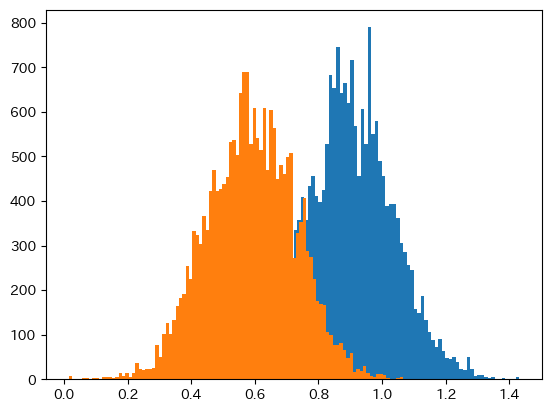

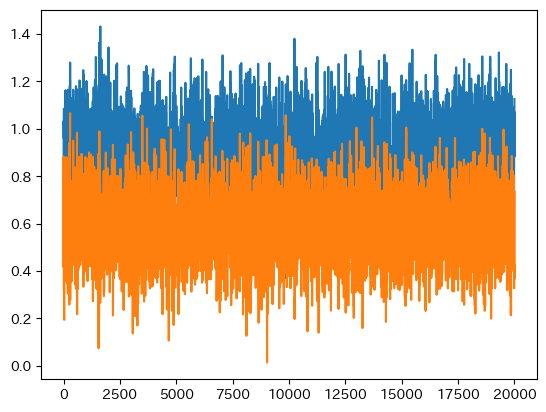

[0.89593102 0.58760047]


In [38]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
n = t_max/h
k_0 = 1
samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,k_0,Z,n,h), 20000, 0.1,2)
plt.hist(samples1[:,0],bins = 100)
plt.hist(samples1[:,1],bins = 100)
plt.show()
plt.plot(samples1[:,0])
plt.plot(samples1[:,1])
plt.show()
print(samples1.mean(axis = 0))

$k_0 =2$

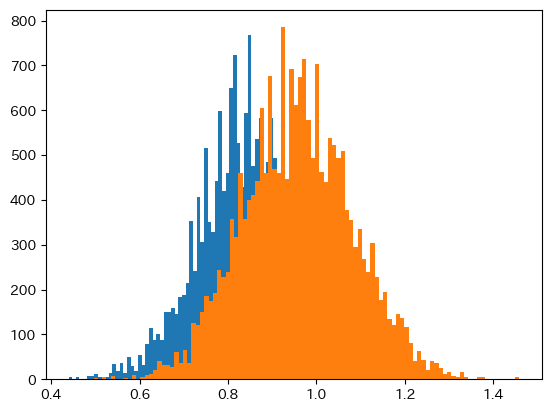

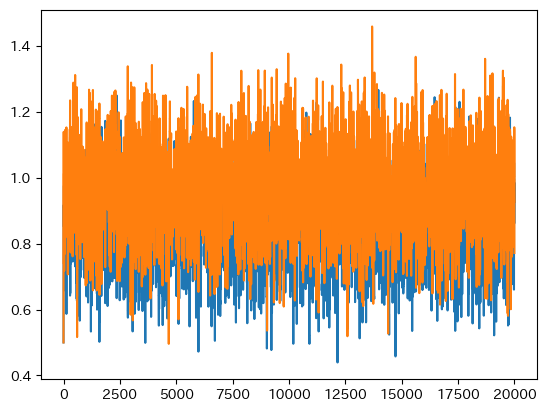

[0.85610148 0.95894427]


In [39]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
n = t_max/h
k_0 = 2
samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,k_0,Z,n,h), 20000, 0.1,2)
plt.hist(samples1[:,0],bins = 100)
plt.hist(samples1[:,1],bins = 100)
plt.show()
plt.plot(samples1[:,0])
plt.plot(samples1[:,1])
plt.show()
print(samples1.mean(axis = 0))

$k_0= 3$

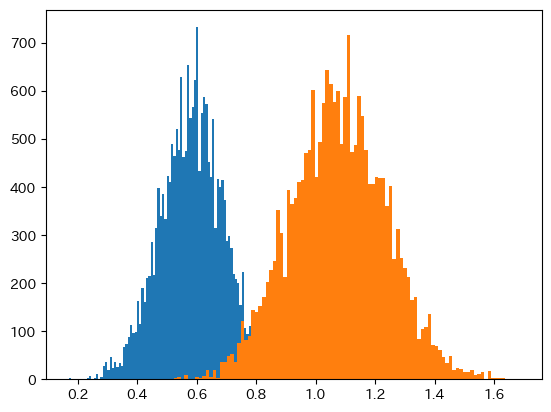

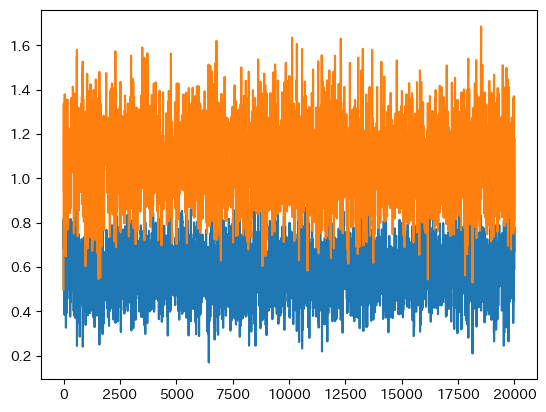

[0.58513664 1.07684278]


In [40]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
n = t_max/h
k_0 = 3
samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,k_0,Z,n,h), 20000, 0.1,2)
plt.hist(samples1[:,0],bins = 100)
plt.hist(samples1[:,1],bins = 100)
plt.show()
plt.plot(samples1[:,0])
plt.plot(samples1[:,1])
plt.show()
print(samples1.mean(axis = 0))

In [405]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.01
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

100%|██████████| 10/10 [02:50<00:00, 17.01s/it]


,theta1,theta2
k=1 mean,0.967065,0.959805
k=1 std,0.114803,0.145620
k=2 mean,0.991472,0.956819
k=2 std,0.112304,0.143031
k=3 mean,0.987977,0.957978
k=3 std,0.112947,0.149662
k=4 mean,0.987164,0.955204
k=4 std,0.117482,0.141154
k=5 mean,0.987453,0.956505
k=5 std,0.112981,0.146831


In [346]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.05
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


,theta1,theta2
k=1 mean,0.962667,0.952115
k=1 std,0.095646,0.141241
k=2 mean,1.036767,0.977067
k=2 std,0.119141,0.144847
k=3 mean,0.964569,0.984573
k=3 std,0.094644,0.152724
k=4 mean,0.991448,0.978463
k=4 std,0.106000,0.146812
k=5 mean,0.984603,0.977088
k=5 std,0.102648,0.145401


In [345]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.1
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


,theta1,theta2
k=1 mean,0.946699,0.931324
k=1 std,0.091816,0.136863
k=2 mean,1.262997,0.975719
k=2 std,0.229950,0.149508
k=3 mean,8.167676,8.197893
k=3 std,3.633577,3.501850
k=4 mean,6.118402,0.932896
k=4 std,0.762600,0.165048
k=5 mean,9.083186,9.070367
k=5 std,2.726372,2.669583


In [347]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 10.0
    dt = 0.0001  # 最大時間の例
    h = 0.01
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


,theta1,theta2
k=1 mean,1.208661,1.121830
k=1 std,0.400058,0.463603
k=2 mean,1.276959,1.126028
k=2 std,0.418001,0.485340
k=3 mean,1.305093,1.082079
k=3 std,0.412315,0.416576
k=4 mean,1.279688,1.131650
k=4 std,0.463289,0.449154
k=5 mean,1.270481,1.119161
k=5 std,0.394179,0.485566


In [348]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 10.0
    dt = 0.0001  # 最大時間の例
    h = 0.05
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


,theta1,theta2
k=1 mean,1.232648,1.099611
k=1 std,0.419302,0.437158
k=2 mean,1.580642,1.139362
k=2 std,0.775735,0.460623
k=3 mean,1.324801,1.139024
k=3 std,0.460901,0.451805
k=4 mean,3.821500,1.014822
k=4 std,4.014122,0.275225
k=5 mean,1.289093,1.164256
k=5 std,0.439077,0.531577


In [349]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 10.0
    dt = 0.0001  # 最大時間の例
    h = 0.1
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


,theta1,theta2
k=1 mean,1.168402,1.074196
k=1 std,0.393607,0.406890
k=2 mean,4.392500,1.230212
k=2 std,3.721913,0.542841
k=3 mean,5.530311,5.744746
k=3 std,4.459390,4.248083
k=4 mean,7.760461,0.795744
k=4 std,1.862015,0.513515
k=5 mean,5.487294,5.598707
k=5 std,4.504737,4.141047


In [ ]:

from scipy.misc import derivative
import numpy as np

def hessian(f, x, epsilon=1e-5):
    n = len(x)
    hessian_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            def f_ij(x):
                x = np.array(x)
                return f(x)
            if i == j:
                hessian_matrix[i, j] = derivative(lambda xi: derivative(lambda xj: f_ij(x), x[j], dx=epsilon, n=1), x[i], dx=epsilon, n=1)
            else:
                x1 = np.array(x, dtype=float)
                x2 = np.array(x, dtype=float)
                x1[i] += epsilon
                x1[j] += epsilon
                x2[i] -= epsilon
                x2[j] -= epsilon
                hessian_matrix[i, j] = (f_ij(x1) - 2*f_ij(x) + f_ij(x2)) / (epsilon ** 2)
    return hessian_matrix
import numpy as np
from scipy.optimize import approx_fprime

def one_step(f,x):
    grad = approx_fprime(x, f, 1e-6)
    hess = hessian(f, x)
    return x - np.linalg.inv(hess).dot(grad)

